In [6]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
# -------------------------
# Environment & traffic params
# -------------------------
T_p = 1             # time quantum (seconds)
L = 300             # packet/bit size placeholder (not used explicitly)
Q_max = 60          # threshold for high queue
Q_threshold = 40   # threshold for low queue
W_max = 300         # max bandwidth (units treated as service capacity per second)
cycles = 24         # number of cycles per episode (hours)
second_in_hour = 3600            # seconds per cycle (1 hour)
episodes = 1000     # reduce for faster runs; set to 1000 for full run
hours_in_day = 24   # hours in a day
p_viloation_threshold = 0.1  # threshold for penalty
p_drop_threshold = 0.01      # threshold for penalty

# action levels (same cardinality as original)
W_levels = np.linspace(0, W_max, 26)  # 26 bandwidth choices (0, 20, 40, ... if W_max=500)
print(W_levels)

[  0.  12.  24.  36.  48.  60.  72.  84.  96. 108. 120. 132. 144. 156.
 168. 180. 192. 204. 216. 228. 240. 252. 264. 276. 288. 300.]


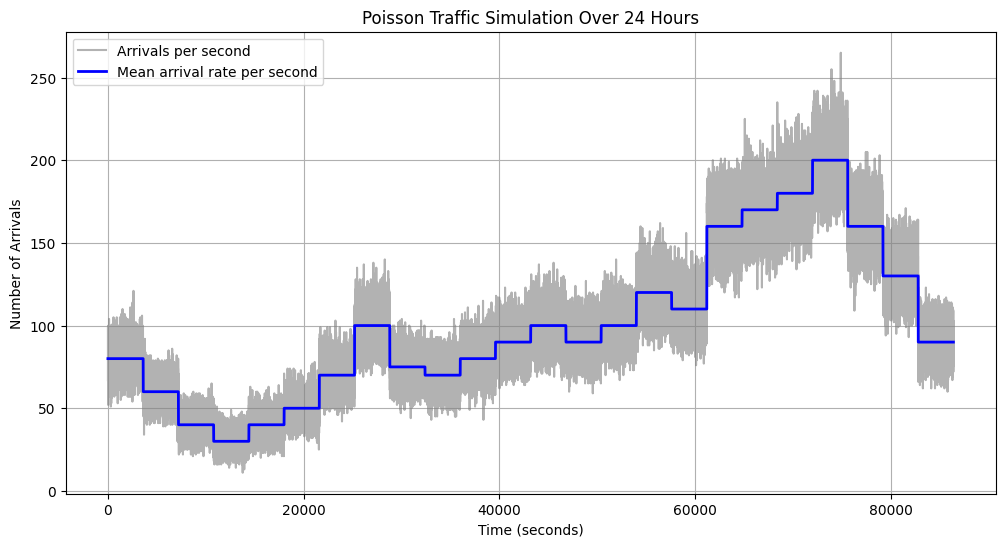

In [8]:
def generate_poisson_traffic(λ, duration):
    R = np.random.rand(int(λ * duration * 2))
    IAT = -np.log(1 - R) / λ
    arrivals = np.cumsum(IAT)
    return arrivals[arrivals <= duration]


mean_arrival_rates = np.array([80, 60, 40, 30, 40, 50, 70, 100, 75, 70, 80, 90, 100, 90, 100, 120, 110, 160, 170, 180, 200, 160, 130, 90,])

total_duration = 24 * 3600
all_arrivals = []

for hour, λ in enumerate(mean_arrival_rates):
    arrivals = generate_poisson_traffic(λ, 3600)
    arrivals += hour * 3600
    all_arrivals.extend(arrivals)

all_arrivals = np.array(all_arrivals)
time_bins = np.arange(0, total_duration + 1, 1)
bits_arrival_counts, _ = np.histogram(all_arrivals, bins=time_bins)

mean_per_second = np.repeat(mean_arrival_rates, 3600)

plt.figure(figsize=(12, 6))
plt.plot(time_bins[:-1], bits_arrival_counts, color="gray", alpha=0.6, label="Arrivals per second")
plt.plot(time_bins[:-1], mean_per_second, color="blue", linewidth=2, label="Mean arrival rate per second")
plt.xlabel("Time (seconds)")
plt.ylabel("Number of Arrivals")
plt.title("Poisson Traffic Simulation Over 24 Hours")
plt.legend()
plt.grid()
plt.show()

In [9]:
def discretize_queue_state(Qlength):
    if Qlength <= Q_threshold:
        return 0
    elif Qlength < Q_max:
        return 1
    else:
        return 2

def encode_state(Qlength, average_arrival):
    one_hot_arrival = np.zeros(21, dtype=np.float32)
    arrival_bin = int(min(max(0, average_arrival//10), 20))
    one_hot_arrival[arrival_bin] = 1.0
    one_hot_queue = np.zeros(3, dtype=np.float32)
    one_hot_queue[discretize_queue_state(Qlength)] = 1.0
    return np.concatenate([one_hot_arrival, one_hot_queue], axis=0)

def update_queue(Q, arrivals, u):
    new_packets = arrivals
    Q_new = (((Q*L) + new_packets - u) * T_p / L)
    return max(0, min(Q_new, Q_max + 1))

def env_rollout_one_cycle(cycle_idx, action_bandwidth, Qlength_init):
    Qlength = float(Qlength_init)
    Q_history = []
    for t in range(second_in_hour):
        arrivals_this_sec = bits_arrival_counts[cycle_idx * second_in_hour + t]
        Qlength = update_queue(Qlength, arrivals_this_sec, action_bandwidth)
        Q_history.append(Qlength)

    Q_mean = np.mean(Q_history)
    p_violation = np.mean(np.array(Q_history) >= Q_threshold)
    p_drop = np.mean(np.array(Q_history) >= Q_max)

    # Continuous reward shaping
    reward = - (10 * p_violation +  50 * p_drop)
    if (action_bandwidth != 0 and p_violation < 0.1 and p_drop < 0.01): 
        reward += Q_mean + ( mean_arrival_rates[cycle_idx] / (action_bandwidth))

    return reward, p_drop, p_violation,  float(Q_history[-1])

In [10]:
# -------------------------
# DQN
# -------------------------
class DQNNet(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

state_size = 24
action_size = len(W_levels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQNNet(state_size, action_size).to(device)
target_net = DQNNet(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
memory = deque(maxlen=50000)
batch_size = 64
gamma = 0.99

def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randrange(action_size)
    else:
        with torch.no_grad():
            return policy_net(torch.tensor(state, dtype=torch.float32, device=device)).argmax().item()

def optimize_model():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32, device=device)
    actions = torch.tensor(actions, dtype=torch.int64, device=device).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32, device=device)

    q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
    target = rewards + gamma * next_q_values

    loss = nn.MSELoss()(q_values, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [11]:
# -------------------------
# Training loop
# -------------------------
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
target_update = 20

reward_history = []
bandwidth_history = []
p_violation_history = []
p_drop_history = []

for ep in range(episodes):
    Qlength = 0
    ep_reward = 0
    ep_bandwidth = 0
    ep_p_violation = 0
    ep_p_drop = 0
    for cycle in range(cycles):
        mean_arrival = mean_arrival_rates[cycle]
        state = encode_state(Qlength, mean_arrival)

        action_idx = select_action(state, epsilon)
        action_bandwidth = W_levels[action_idx]
        #print(f"Episode {ep}, Cycle {cycle}, Mean Arrival: {mean_arrival:.2f}, Selected Bandwidth: {action_bandwidth}, Action Index: {action_idx}")

        reward, p_violation, p_drop, Qlength = env_rollout_one_cycle(cycle, action_bandwidth, Qlength)

        # collecting data for analysis
        ep_bandwidth += action_bandwidth
        ep_p_violation += p_violation
        ep_p_drop += p_drop
        next_state = encode_state(Qlength, mean_arrival)

        memory.append((state, action_idx, reward, next_state))
        ep_reward += reward

        optimize_model()
    
    # appending data for analysis
    reward_history.append(ep_reward)
    p_violation_history.append(ep_p_violation / cycles)
    p_drop_history.append(ep_p_drop / cycles)
    bandwidth_history.append(ep_bandwidth)

    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    if ep % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {ep}, Reward: {ep_reward:.2f}, Bandwidth: {ep_bandwidth:.2f} Epsilon: {epsilon:.2f}")

Episode 0, Reward: -558.74, Bandwidth: 3420.00 Epsilon: 0.99
Episode 1, Reward: -363.85, Bandwidth: 3720.00 Epsilon: 0.99
Episode 2, Reward: -443.61, Bandwidth: 3144.00 Epsilon: 0.99


C:\Users\HP\AppData\Local\Temp\ipykernel_22136\3276648035.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  states = torch.tensor(states, dtype=torch.float32, device=device)


Episode 3, Reward: -474.94, Bandwidth: 3612.00 Epsilon: 0.98
Episode 4, Reward: -326.08, Bandwidth: 3996.00 Epsilon: 0.98
Episode 5, Reward: -282.36, Bandwidth: 3792.00 Epsilon: 0.97
Episode 6, Reward: -626.47, Bandwidth: 3096.00 Epsilon: 0.97
Episode 7, Reward: -379.64, Bandwidth: 3684.00 Epsilon: 0.96
Episode 8, Reward: -398.82, Bandwidth: 4260.00 Epsilon: 0.96
Episode 9, Reward: -372.98, Bandwidth: 3960.00 Epsilon: 0.95
Episode 10, Reward: -186.92, Bandwidth: 4536.00 Epsilon: 0.95
Episode 11, Reward: -267.55, Bandwidth: 3360.00 Epsilon: 0.94
Episode 12, Reward: -439.73, Bandwidth: 3684.00 Epsilon: 0.94
Episode 13, Reward: -530.54, Bandwidth: 3276.00 Epsilon: 0.93
Episode 14, Reward: -382.32, Bandwidth: 4104.00 Epsilon: 0.93
Episode 15, Reward: -453.18, Bandwidth: 3540.00 Epsilon: 0.92
Episode 16, Reward: -235.17, Bandwidth: 4008.00 Epsilon: 0.92
Episode 17, Reward: -425.85, Bandwidth: 3480.00 Epsilon: 0.91
Episode 18, Reward: -486.08, Bandwidth: 3408.00 Epsilon: 0.91
Episode 19, Rew

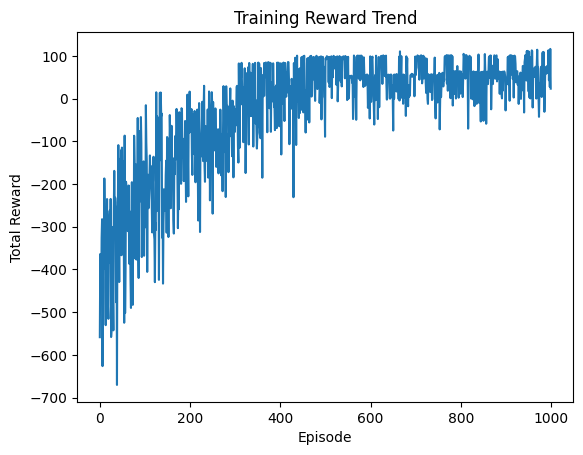

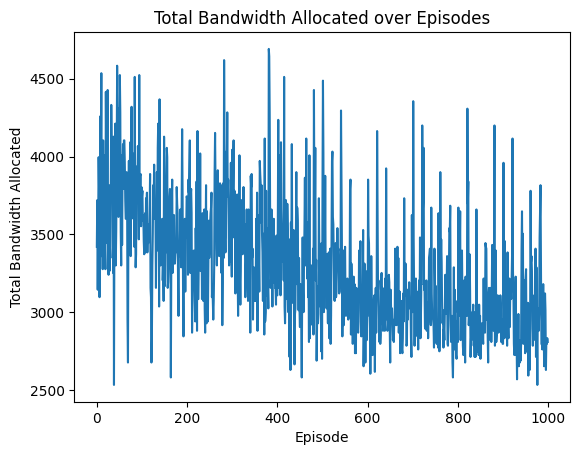

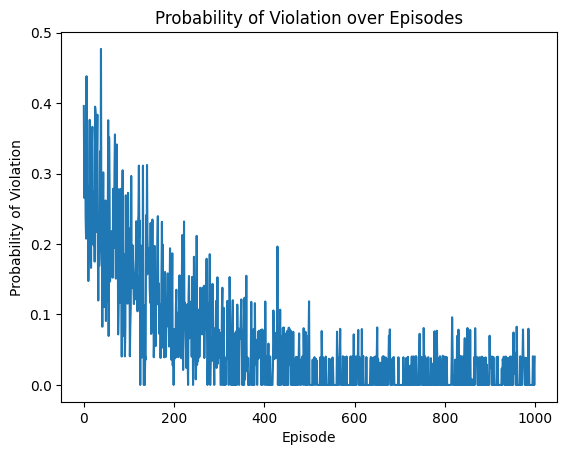

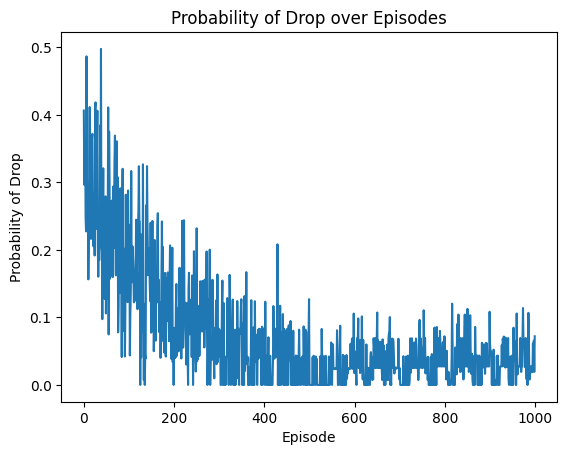

In [14]:
# -------------------------
# Plot
# -------------------------
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward Trend")
plt.show()

# -------------------------
plt.plot(bandwidth_history)
plt.xlabel("Episode")
plt.ylabel("Total Bandwidth Allocated") 
plt.title("Total Bandwidth Allocated over Episodes")
plt.show()

# -------------------------
plt.plot(p_violation_history)
plt.ylabel("Probability of Violation")
plt.xlabel("Episode")
plt.title("Probability of Violation over Episodes")
plt.show()

# -------------------------
plt.plot(p_drop_history)
plt.ylabel("Probability of Drop")   
plt.xlabel("Episode")
plt.title("Probability of Drop over Episodes")
plt.show()